In [1]:
import sys
import time
import importlib
import uuid
import glob
import base64
import cv2
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import tensorflow as tf
import tensorflow_hub as hub

C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

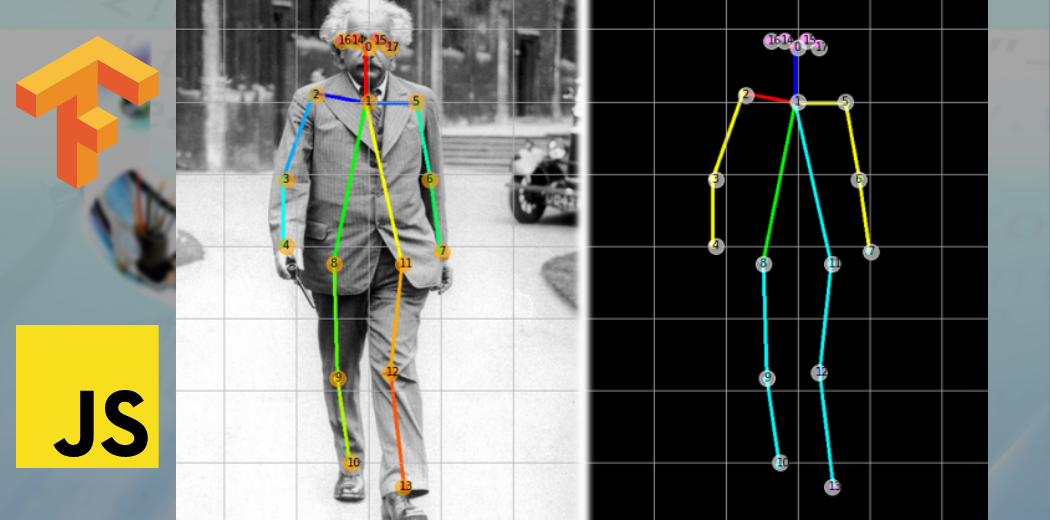

In [5]:
FRAME_RATE = .2

def draw_image(image, keypoints):
    display_image = tf.cast(tf.image.resize_with_pad(
        image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints)

    plt.figure(figsize=(5, 5))
    plt.imshow(output_overlay)
    _ = plt.axis('off')


def process_image_movenet(image):
    image = tf.convert_to_tensor(image, dtype=tf.int32)
    image = tf.expand_dims(image, axis=0)

    image_resized = tf.cast(tf.image.resize_with_pad(image, 192, 192), dtype=tf.int32)
    
    keypoints_with_scores = movenet(image_resized)

    return image, keypoints_with_scores['output_0']

def process_video_movenet(video_path):
    i, last_time = 0, 0
    cam = cv2.VideoCapture(video_path)

    features = []
    times = []
    images = []
    while cam.isOpened():
        ret_val, image = cam.read()

        this_time = cam.get(cv2.CAP_PROP_POS_MSEC)/1000

        if i > 0 and this_time == 0.0:
            break

        if last_time > 0 and (this_time - last_time) < FRAME_RATE:
            continue

        last_time = this_time
        
        times.append(this_time)

        images.append(image)
        image, keypoints = process_image_movenet(image)

        input_features = keypoints.numpy()[0][0]

        features.append(input_features)
       
        i += 1

    cam.release()
    return features, images, times

features, images, times = process_video_movenet('D:\\zeus\\Projetos\\linkfit\\videos\\elevacao_bracos_acima_da_cabeca.mp4')

In [6]:
features

[array([[0.20993826, 0.4919967 , 0.4853969 ],
        [0.19664341, 0.5088253 , 0.8199086 ],
        [0.1953219 , 0.4783073 , 0.5272938 ],
        [0.2170705 , 0.5297311 , 0.77481794],
        [0.21552025, 0.4626194 , 0.71017337],
        [0.29720438, 0.5694761 , 0.8462404 ],
        [0.299446  , 0.42614624, 0.85149646],
        [0.42786998, 0.59610385, 0.70470315],
        [0.42346752, 0.4158245 , 0.67914295],
        [0.523307  , 0.6115073 , 0.58977747],
        [0.52859867, 0.39250875, 0.5337365 ],
        [0.49666712, 0.5433459 , 0.8066876 ],
        [0.49744076, 0.45742816, 0.7823702 ],
        [0.66206026, 0.575276  , 0.75056857],
        [0.6602496 , 0.4250389 , 0.7113704 ],
        [0.8576933 , 0.5916561 , 0.7960043 ],
        [0.8580162 , 0.4049091 , 0.8607797 ]], dtype=float32),
 array([[0.20906979, 0.4922089 , 0.47198477],
        [0.19612859, 0.5087035 , 0.81290674],
        [0.19494468, 0.4781365 , 0.5263918 ],
        [0.21679819, 0.5297682 , 0.7799891 ],
        [0.215560

In [7]:
columns = ['NOSE_X', 'NOSE_Y', 'NOSE_CONF',
           'LEYE_X', 'LEYE_Y', 'LEYE_CONF',
           'REYE_X', 'REYE_Y', 'REYE_CONF',
           'LEAR_X', 'LEAR_Y', 'LEAR_CONF',
           'REAR_X', 'REAR_Y', 'REAR_CONF',
           'LSHOULDER_X', 'LSHOULDER_Y', 'LSHOULDER_CONF',
           'RSHOULDER_X', 'RSHOULDER_Y', 'RSHOULDER_CONF',
           'LELBOW_X', 'LELBOW_Y', 'LELBOW_CONF',
           'RELBOW_X', 'RELBOW_Y', 'RELBOW_CONF',
           'LWRIST_X', 'LWRIST_Y', 'LWRIST_CONF',
            'RWRIST_X', 'RWRIST_Y', 'RWRIST_CONF',
            'LHIP_X', 'LHIP_Y', 'LHIP_CONF',
            'RHIP_X', 'RHIP_Y', 'RHIP_CONF',
           'LKNEE_X', 'LKNEE_Y', 'LKNEE_CONF',
            'RKNEE_X', 'RKNEE_Y', 'RKNEE_CONF',
            'RANKLE_X', 'RANKLE_Y', 'RANKLE_CONF',
            'LANKLE_X', 'LANKLE_Y', 'LANKLE_CONF',
            ]

def features_to_dataframe(features):
    features_ = []
    for f in features:
        new_f = []
        for coord in f:
            if coord is not None:
                new_f.append(coord[0])
                new_f.append(coord[1])
                new_f.append(coord[2])
            else:
                new_f.append(None)
                new_f.append(None)
                new_f.append(None)
        features_.append(new_f)

    return pd.DataFrame(features_, columns=columns)

df_features = features_to_dataframe(features)

cols = [col for col in df_features.columns if col.endswith('_X') or col.endswith('_Y')]
df_features = df_features[cols]
df_features['images'] = images

In [8]:
df_features

,NOSE_X,NOSE_Y,LEYE_X,LEYE_Y,REYE_X,REYE_Y,LEAR_X,LEAR_Y,REAR_X,REAR_Y,...,RHIP_Y,LKNEE_X,LKNEE_Y,RKNEE_X,RKNEE_Y,RANKLE_X,RANKLE_Y,LANKLE_X,LANKLE_Y,images
0,0.209938,0.491997,0.196643,0.508825,0.195322,0.478307,0.217071,0.529731,0.215520,0.462619,...,0.457428,0.662060,0.575276,0.660250,0.425039,0.857693,0.591656,0.858016,0.404909,"[[[179, 179, 179], [179, 179, 179], [179, 179,..."
1,0.209070,0.492209,0.196129,0.508703,0.194945,0.478137,0.216798,0.529768,0.215560,0.462708,...,0.458759,0.659446,0.576618,0.659734,0.425164,0.864400,0.592834,0.859483,0.404166,"[[[179, 179, 179], [179, 179, 179], [179, 179,..."
2,0.213519,0.495408,0.199767,0.512291,0.198888,0.481537,0.220133,0.532944,0.217667,0.465988,...,0.463477,0.656742,0.582887,0.658592,0.424020,0.852797,0.594138,0.857973,0.405234,"[[[181, 181, 181], [181, 181, 181], [181, 181,..."
3,0.212106,0.498566,0.198613,0.514661,0.198117,0.484630,0.222758,0.535865,0.219211,0.468417,...,0.459650,0.656883,0.582713,0.659191,0.421856,0.850587,0.594270,0.856878,0.403062,"[[[185, 185, 185], [185, 185, 185], [185, 185,..."
4,0.214090,0.499507,0.200398,0.516574,0.199838,0.486600,0.222988,0.537199,0.218346,0.469652,...,0.457516,0.657868,0.586381,0.659821,0.416957,0.861870,0.602160,0.861358,0.402921,"[[[185, 184, 186], [185, 184, 186], [185, 184,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,0.219403,0.500347,0.203116,0.515173,0.204068,0.486201,0.227279,0.535991,0.226063,0.467679,...,0.460995,0.690216,0.590793,0.681684,0.418561,0.868817,0.602220,0.869599,0.407620,"[[[183, 180, 181], [183, 180, 181], [183, 180,..."
153,0.217226,0.499011,0.202386,0.514313,0.203580,0.485682,0.225674,0.534587,0.226784,0.467549,...,0.461209,0.693596,0.585915,0.685728,0.417906,0.868289,0.599233,0.869310,0.407845,"[[[182, 179, 180], [183, 180, 181], [184, 181,..."
154,0.219275,0.497721,0.204654,0.512955,0.205347,0.483569,0.225058,0.534119,0.226737,0.465336,...,0.462208,0.693554,0.585775,0.685179,0.417771,0.868807,0.598639,0.870407,0.408525,"[[[182, 179, 180], [183, 180, 181], [184, 181,..."
155,0.219106,0.498892,0.204887,0.513971,0.205151,0.484220,0.225376,0.534477,0.227129,0.465877,...,0.464920,0.692156,0.585979,0.685576,0.417178,0.868926,0.598614,0.872734,0.409679,"[[[180, 180, 180], [181, 181, 181], [182, 182,..."


#### interpolação para remover nans

C:\Users\dhiog\AppData\Local\Temp\ipykernel_14340\1292635173.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_features.loc[df_features.sample(frac=0.2).index, 'LSHOULDER_X'] = pd.np.nan


<AxesSubplot: >

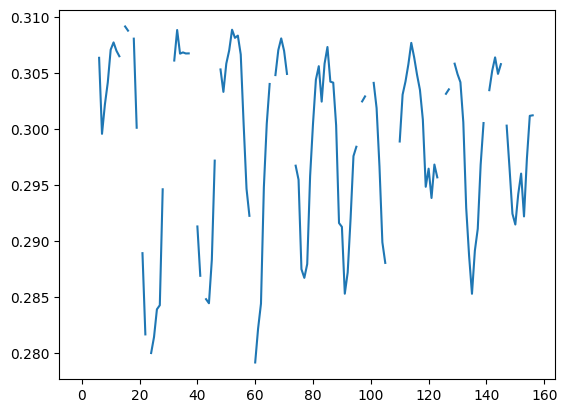

In [9]:
df_features.loc[df_features.sample(frac=0.2).index, 'LSHOULDER_X'] = pd.np.nan
df_features['LSHOULDER_X'].plot()

## Lidando com missing

In [10]:
df_filtered2 = df_features.interpolate()
df_filtered2.fillna((df_filtered2.mean()), inplace=True)

perspective = utils.calculate_camera_perspective(df_filtered2)

C:\Users\dhiog\AppData\Local\Temp\ipykernel_14340\67925.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_filtered2.fillna((df_filtered2.mean()), inplace=True)


<AxesSubplot: >

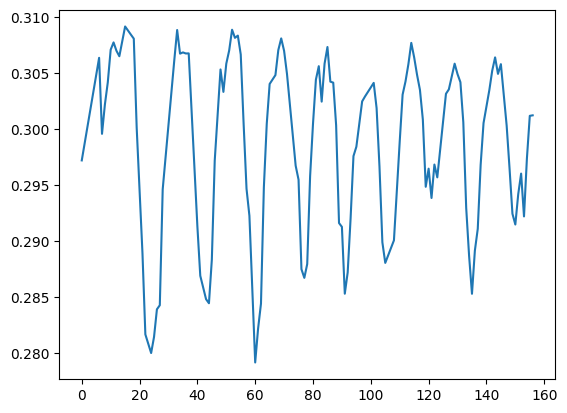

In [11]:
df_filtered2['LSHOULDER_X'].plot()

In [12]:
calcs = df_filtered2.apply(lambda row: utils.calculate_features(row.to_dict(), perspective), axis=1)
df = pd.DataFrame.from_records([c for c in calcs])

In [13]:
df.columns

Index(['RHIP_RKNEE_RANKLE', 'LHIP_LKNEE_LANKLE', 'RSHOULDER_RELBOW_RWRIST',
       'LSHOULDER_LELBOW_LWRIST', 'RLEG', 'LLEG', 'SHOULDER', 'RARM', 'LARM',
       'RANKLE', 'LANKLE'],
      dtype='object')

<AxesSubplot: >

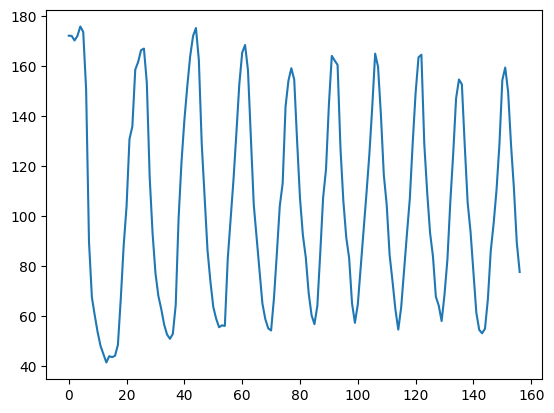

In [14]:
df['RSHOULDER_RELBOW_RWRIST'].plot()

<AxesSubplot: >

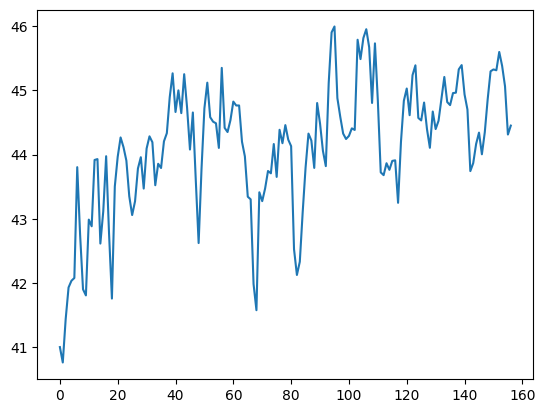

In [15]:
df['LANKLE'].plot()

In [16]:
corr = abs(df.corr())
corr.style.background_gradient(cmap='coolwarm')

,RHIP_RKNEE_RANKLE,LHIP_LKNEE_LANKLE,RSHOULDER_RELBOW_RWRIST,LSHOULDER_LELBOW_LWRIST,RLEG,LLEG,SHOULDER,RARM,LARM,RANKLE,LANKLE
RHIP_RKNEE_RANKLE,1.000000,0.597680,0.162436,0.187665,0.694770,0.577000,0.143324,0.430291,0.435120,0.700721,0.404222
LHIP_LKNEE_LANKLE,0.597680,1.000000,0.108665,0.089792,0.170604,0.633668,0.103785,0.612730,0.623997,0.661482,0.879996
RSHOULDER_RELBOW_RWRIST,0.162436,0.108665,1.000000,0.991262,0.148639,0.088973,0.264658,0.468676,0.420678,0.078327,0.192530
LSHOULDER_LELBOW_LWRIST,0.187665,0.089792,0.991262,1.000000,0.170494,0.108028,0.250520,0.425541,0.384242,0.091715,0.180279
RLEG,0.694770,0.170604,0.148639,0.170494,1.000000,0.512851,0.042091,0.286594,0.272887,0.026286,0.098377
LLEG,0.577000,0.633668,0.088973,0.108028,0.512851,1.000000,0.070313,0.352545,0.346378,0.293249,0.190176
SHOULDER,0.143324,0.103785,0.264658,0.250520,0.042091,0.070313,1.000000,0.050761,0.016971,0.157452,0.088538
RARM,0.430291,0.612730,0.468676,0.425541,0.286594,0.352545,0.050761,1.000000,0.987389,0.313773,0.561133
LARM,0.435120,0.623997,0.420678,0.384242,0.272887,0.346378,0.016971,0.987389,1.000000,0.334082,0.579217
RANKLE,0.700721,0.661482,0.078327,0.091715,0.026286,0.293249,0.157452,0.313773,0.334082,1.000000,0.659408


In [17]:
c = df.corr().abs()
s = c.unstack()

so = s.sort_values(ascending=False, kind="quicksort")

for index, value in so.items():
    if value < .9:
        break

    if index[0] != index[1]:
        print(index, value)

('RSHOULDER_RELBOW_RWRIST', 'LSHOULDER_LELBOW_LWRIST') 0.9912622972921465
('LSHOULDER_LELBOW_LWRIST', 'RSHOULDER_RELBOW_RWRIST') 0.9912622972921465
('RARM', 'LARM') 0.9873887778155732
('LARM', 'RARM') 0.9873887778155732


In [18]:
!pip install yellowbrick

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\dhiog\\appdata\\local\\programs\\python\\python310\\lib\\site-packages\\numpy-1.24.2.dist-info\\METADATA'


[notice] A new release of pip available: 22.2.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


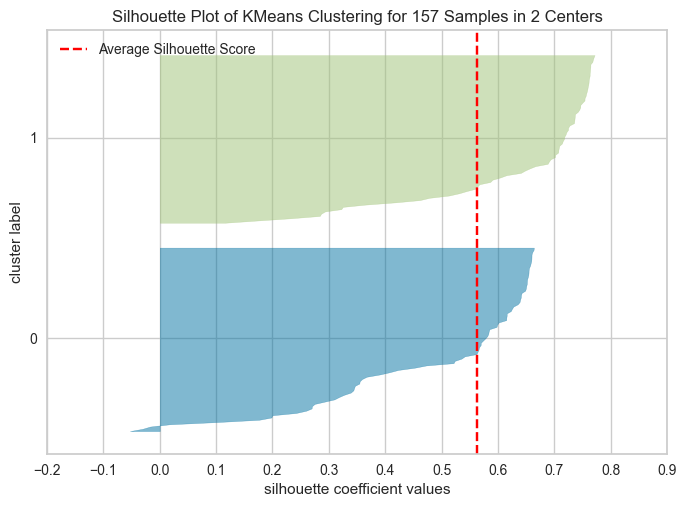

C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


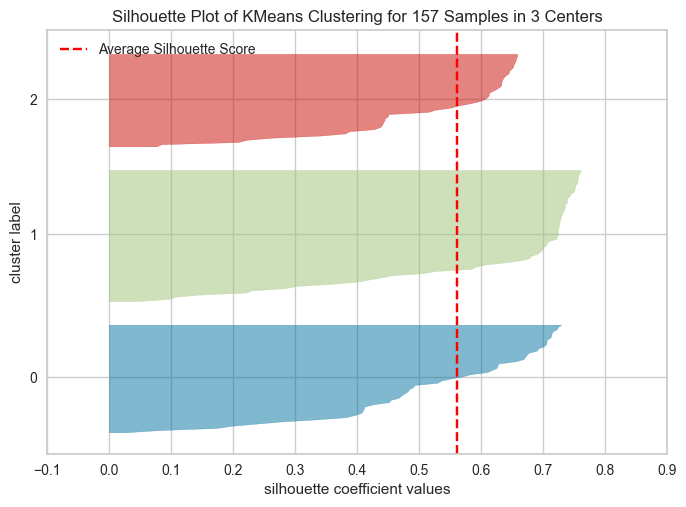

C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


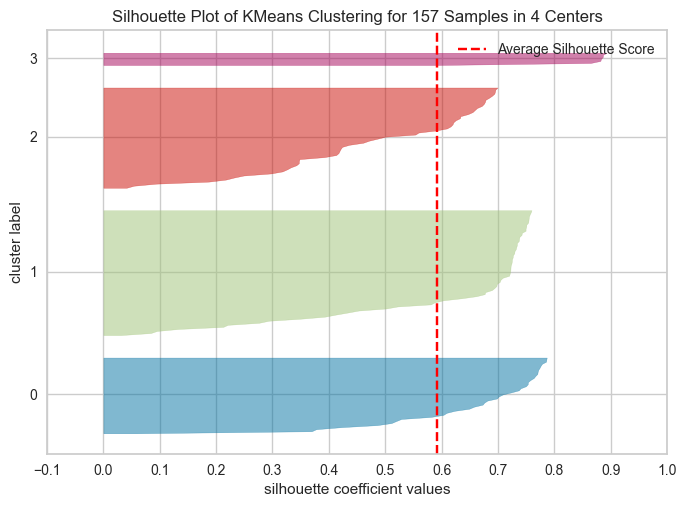

C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


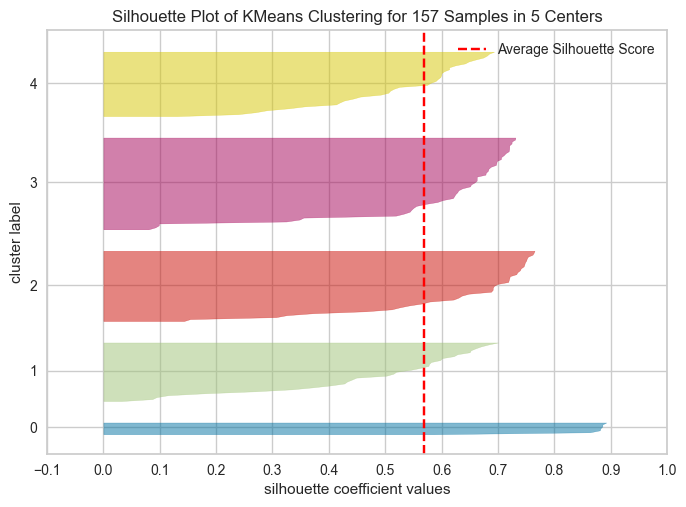

C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


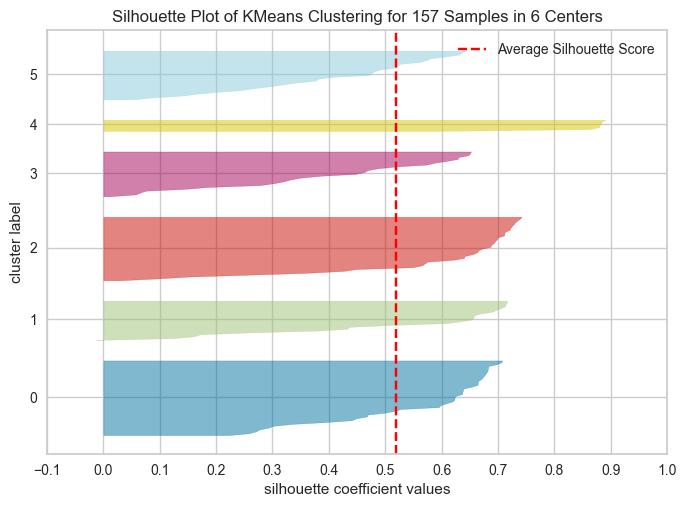

C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


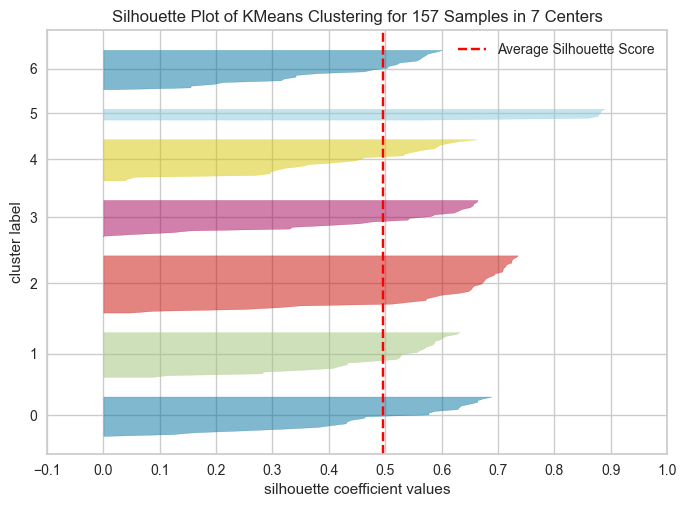

C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


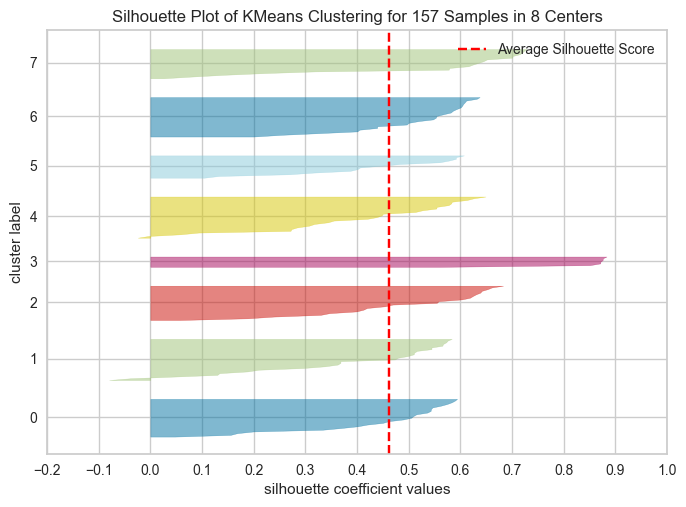

C:\Users\dhiog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


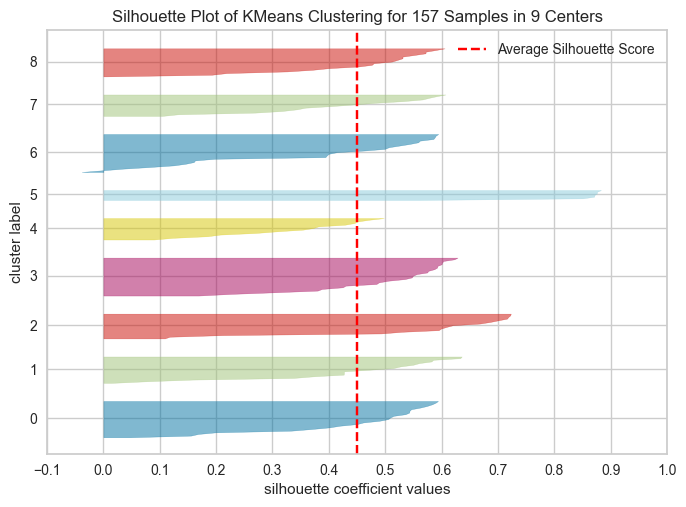

In [19]:
from sklearn import metrics
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

range_n_clusters = range(2,10)

X = df

def show_clusters(data, labels, indx_var1, indx_var2):
    plt.subplots(figsize=(10, 10))
    palette = sns.color_palette('hls', n_colors=len(set(labels)))
    sns.scatterplot(x=data.iloc[:, indx_var1], y=data.iloc[:, indx_var2], hue=labels, palette=palette)
    plt.axis('off')
    plt.show()

davies_bouldin_scores = []

for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
    cluster_labels = km.fit_predict(X)

    dbs = metrics.davies_bouldin_score(X, cluster_labels)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(X)
    visualizer.show();

    davies_bouldin_scores.append(dbs)

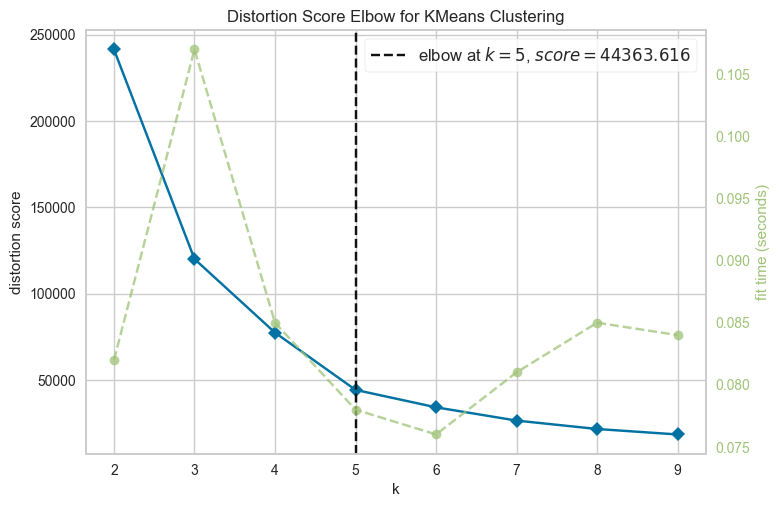

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10)).fit(X)
visualizer.show()

In [22]:
davies_bouldin_scores

[0.6376617434484134,
 0.6007813395624648,
 0.465032757922205,
 0.5109384570035697,
 0.5594479971037526,
 0.6092572682079299,
 0.6566554651933296,
 0.7033993225781209]

In [23]:
km = KMeans(n_clusters=5, init='k-means++', random_state=0)
cluster_labels = km.fit_predict(X)

df_clusters = df.copy()
df_clusters['cluster'] = cluster_labels

In [24]:
df_clusters['cluster'].value_counts()

3    48
2    37
4    34
1    31
0     7
Name: cluster, dtype: int64

In [25]:
import uuid

image_paths = []
for image in images:
    path = f'images/{str(uuid.uuid4())}.png'
    cv2.imwrite(path, image)
    image_paths.append(path)

In [26]:
df_clusters['images'] = image_paths

In [27]:
from IPython.display import Image, display, HTML

def make_html(image):
     return '<img src="{}" style="display:inline;margin:1px;width:200px;height:200px"/>'.format(image)

def save_html(df, html_path):
    grouped_df = df.groupby('cluster')

    final_html = []
    for key, _ in grouped_df:
        imgs = grouped_df.get_group(key)['images']
        htmls = [make_html(x) for x in imgs]
        htmls = f'<div><p>Grupo {key}</p>' + ''.join(htmls) + '</div>'
        final_html.append(htmls)
    
    final_html = '<html><head></head><body>' + ''.join(final_html) + '</body></html>'
    display(HTML(final_html))
    with open(html_path, 'w') as f:
        f.write(final_html)

save_html(df_clusters, 'clustering.html')

In [ ]:
with open('model_elevacao_bracos.pkl', 'wb') as handle:
    pickle.dump(km, handle, protocol=pickle.HIGHEST_PROTOCOL)